We used GPT to help with the coding process

# Text Classification with DistilBERT

This notebook fine-tunes a DistilBERT model for binary text classification to distinguish between accurate and inaccurate scientific text about CRISPR technology.

## Setup and Installation


In [1]:
!pip install transformers datasets evaluate accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


## Import Libraries

Import all necessary libraries for data processing, model training, and evaluation.


In [2]:
import numpy as np
import torch
import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    pipeline,
    set_seed,
    EarlyStoppingCallback,
)

## Configuration

Set up configuration parameters for the model, data, and training process.

In [3]:
# Configuration
MODEL_CHECKPOINT = "distilbert-base-uncased"
DATA_FILE = "test_data.csv"
TEXT_COL = "text"
LABEL_COL = "label"
OUTPUT_DIR = "./my_awesome_model"

SPLIT_SEED = 42   # controls which rows go into train/test (keep this fixed)
MODEL_SEED = 40   # controls model init, dropout, etc. (you can experiment)

## Load Dataset

Load the CSV dataset and split it into training and test sets.

In [5]:
# Load dataset
print("Loading dataset...")
try:
    raw_dataset = load_dataset("csv", data_files=DATA_FILE)
except FileNotFoundError:
    raise FileNotFoundError(
        f"ERROR: '{DATA_FILE}' not found. "
        "Please upload it to the Colab files sidebar."
    )

dataset = raw_dataset["train"]
print("Columns:", dataset.column_names)

# Train/test split (fixed by SPLIT_SEED)
dataset = dataset.train_test_split(test_size=0.2, seed=SPLIT_SEED)
print(dataset)

# Set the model seed for reproducibility
set_seed(MODEL_SEED)

Loading dataset...


Generating train split: 0 examples [00:00, ? examples/s]

Columns: ['label', 'text']
DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 983
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 246
    })
})


## Tokenization

Tokenize the text data using the DistilBERT tokenizer and prepare it for training.

In [6]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples[TEXT_COL],
        truncation=True,
        padding=False,      # dynamic padding with DataCollator
        max_length=256
    )

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Validate label column exists
if LABEL_COL not in tokenized_datasets["train"].column_names:
    raise ValueError(f"Expected label column '{LABEL_COL}' not found in dataset.")

# Keep only necessary columns
tokenized_datasets = tokenized_datasets.remove_columns(
    [c for c in tokenized_datasets["train"].column_names
     if c not in ["input_ids", "attention_mask", LABEL_COL]]
)
tokenized_datasets.set_format("torch")

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

## Setup Metrics and Model

Define evaluation metrics and load the pre-trained DistilBERT model for sequence classification.

In [7]:
# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
mcc_metric = evaluate.load("matthews_correlation")

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"],
        "precision": precision_metric.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=preds, references=labels, average="weighted")["recall"],
        "mcc": mcc_metric.compute(predictions=preds, references=labels)["matthews_correlation"],
    }

# Label mappings
id2label = {0: "INACCURATE", 1: "ACCURATE"}
label2id = {v: k for k, v in id2label.items()}

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

# Optional: Freeze most of DistilBERT (commented out by default)
# Uncomment to freeze encoder and only train classification head:
# for param in model.distilbert.parameters():
#     param.requires_grad = False
# for param in model.distilbert.transformer.layer[-1].parameters():
#     param.requires_grad = True

# Count trainable parameters
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_total = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {num_trainable} / {num_total} "
      f"({100 * num_trainable / num_total:.2f}%)")



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 66955010 / 66955010 (100.00%)


## Training Configuration

Configure training arguments including learning rate, batch size, number of epochs, and evaluation strategy.

In [8]:
# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    logging_strategy="steps",
    logging_steps=50,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=MODEL_SEED,
)


Using device: cuda


In [9]:
# Create trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


/tmp/ipython-input-2035606347.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train Model

Train the model and evaluate on both training and test sets.


In [10]:
# Train the model
print("Starting training...")
train_result = trainer.train()
print(train_result)

# Evaluate on train and test sets
print("\n" + "="*60)
print("EVALUATING ON TRAIN AND TEST")
print("="*60)

train_metrics = trainer.evaluate(eval_dataset=tokenized_datasets["train"])
print("Train metrics:", train_metrics)

test_metrics = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print("Test metrics:", test_metrics)

print("\nSummary:")
print(f"Train accuracy: {train_metrics['eval_accuracy']:.4f}")
print(f"Test  accuracy: {test_metrics['eval_accuracy']:.4f}")
print(f"Train F1:      {train_metrics['eval_f1']:.4f}")
print(f"Test  F1:      {test_metrics['eval_f1']:.4f}")

# Save final model & tokenizer
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.698200,0.692601,0.524390,0.360780,0.274985,0.524390,0.000000
2,0.686600,0.610050,0.756098,0.756178,0.756359,0.756098,0.511488
3,0.588100,0.416428,0.800813,0.800770,0.800754,0.800813,0.600537
4,0.393600,0.405946,0.825203,0.824653,0.826337,0.825203,0.650078
5,0.277200,0.409627,0.792683,0.792638,0.797035,0.792683,0.589799
6,0.225800,0.429068,0.796748,0.796748,0.800549,0.796748,0.597297


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=372, training_loss=0.4474285161623391, metrics={'train_runtime': 93.023, 'train_samples_per_second': 63.404, 'train_steps_per_second': 3.999, 'total_flos': 388658054029764.0, 'train_loss': 0.4474285161623391, 'epoch': 6.0})

EVALUATING ON TRAIN AND TEST


Train metrics: {'eval_loss': 0.255752831697464, 'eval_accuracy': 0.8952187182095626, 'eval_f1': 0.8950483075938906, 'eval_precision': 0.8958652530552269, 'eval_recall': 0.8952187182095626, 'eval_mcc': 0.7904188618995509, 'eval_runtime': 1.8895, 'eval_samples_per_second': 520.248, 'eval_steps_per_second': 32.813, 'epoch': 6.0}
Test metrics: {'eval_loss': 0.4059459865093231, 'eval_accuracy': 0.8252032520325203, 'eval_f1': 0.8246533296793642, 'eval_precision': 0.8263373394603512, 'eval_recall': 0.8252032520325203, 'eval_mcc': 0.6500779100053823, 'eval_runtime': 0.4922, 'eval_samples_per_second': 499.752, 'eval_steps_per_second': 32.504, 'epoch': 6.0}

Summary:
Train accuracy: 0.8952
Test  accuracy: 0.8252
Train F1:      0.8950
Test  F1:      0.8247


('./my_awesome_model/tokenizer_config.json',
 './my_awesome_model/special_tokens_map.json',
 './my_awesome_model/vocab.txt',
 './my_awesome_model/added_tokens.json',
 './my_awesome_model/tokenizer.json')

## Inference Example

Test the trained model on a sample text to see predictions in action.


In [11]:
# Inference example
print("\n" + "=" * 70)
print("INFERENCE EXAMPLE")
print("=" * 70)

example_text = (
    "CRISPR-Cas9 creates double-strand breaks in DNA through homologous recombination repair."
)

clf = pipeline(
    "text-classification",
    model=OUTPUT_DIR,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
)

result = clf(example_text, top_k=None)  # get all label scores

print(f"Text: {example_text}")
print(f"Raw prediction: {result}")
best = max(result, key=lambda x: x["score"])
print(f"Predicted label: {best['label']} (score={best['score']:.4f})")


Device set to use cuda:0



INFERENCE EXAMPLE
Text: CRISPR-Cas9 creates double-strand breaks in DNA through homologous recombination repair.
Raw prediction: [{'label': 'ACCURATE', 'score': 0.8519209027290344}, {'label': 'INACCURATE', 'score': 0.14807909727096558}]
Predicted label: ACCURATE (score=0.8519)


## Visualizations

Visualize training progress and model performance metrics.


### Training and Validation Loss


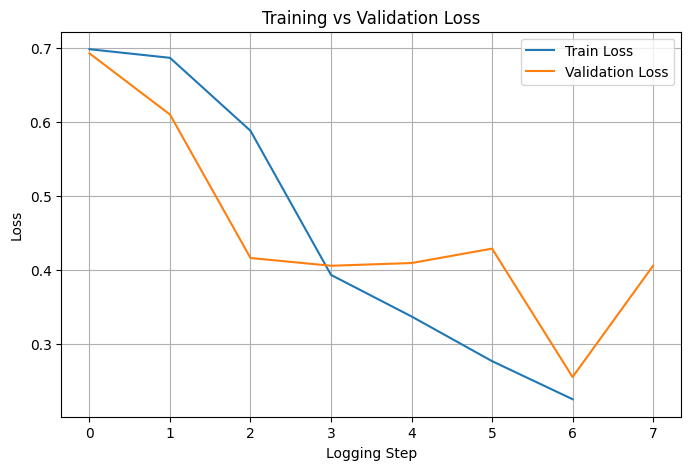

In [12]:
import matplotlib.pyplot as plt

# Extract loss logs
train_loss = [entry["loss"] for entry in trainer.state.log_history if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in trainer.state.log_history if "eval_loss" in entry]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Validation F1 Score Over Time


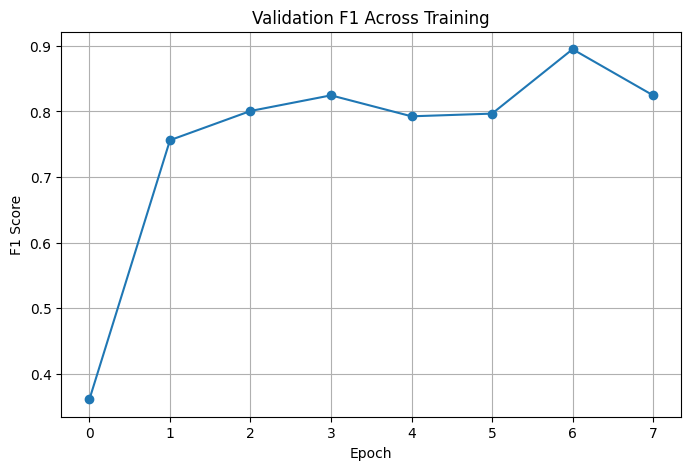

In [13]:
eval_f1 = [entry["eval_f1"] for entry in trainer.state.log_history if "eval_f1" in entry]

plt.figure(figsize=(8, 5))
plt.plot(eval_f1, marker='o')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Across Training")
plt.grid(True)
plt.show()


### Confusion Matrix

Visualize the confusion matrix to see how the model performs on each class.


<Figure size 600x500 with 0 Axes>

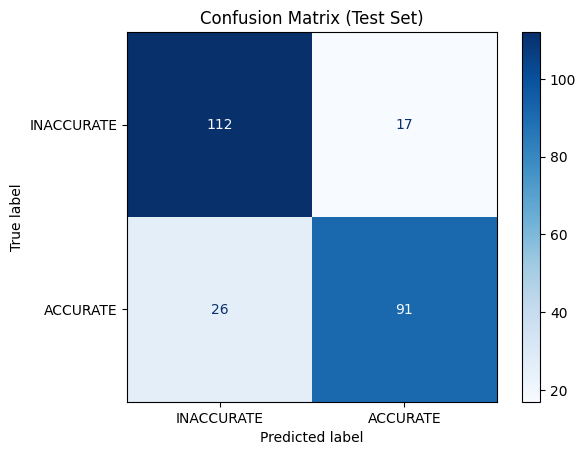

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for test set
preds_output = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["INACCURATE", "ACCURATE"])

plt.figure(figsize=(6, 5))
disp.plot(values_format='d', cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()


### Performance Metrics Bar Chart

Compare all performance metrics (Accuracy, Precision, Recall, F1, MCC) on the test set.


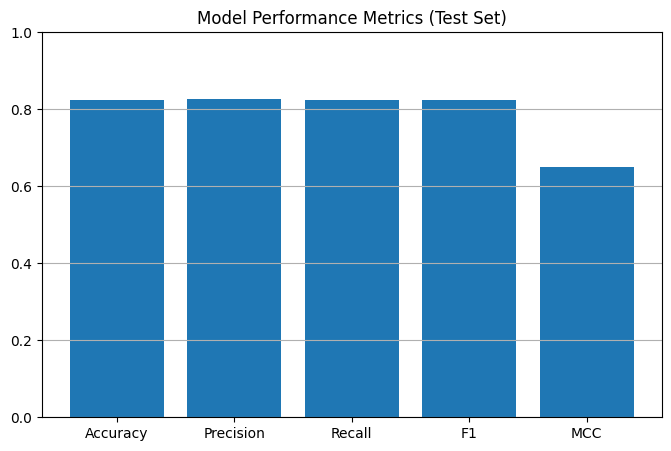

In [15]:
metrics = {
    "Accuracy": test_metrics["eval_accuracy"],
    "Precision": test_metrics["eval_precision"],
    "Recall": test_metrics["eval_recall"],
    "F1": test_metrics["eval_f1"],
    "MCC": test_metrics["eval_mcc"],
}

plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values())
plt.title("Model Performance Metrics (Test Set)")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


## Model vs Random Baseline Comparison

Compare the trained model's performance against a random baseline to verify it's learning meaningful patterns.



RANDOM BASELINE COMPARISON
Model Metrics (test set):
accuracy:  0.8252
f1:        0.8247
precision: 0.8263
recall:    0.8252
mcc:       0.6501

Random Baseline Metrics:
accuracy: 0.500000
f1: 0.499297
precision: 0.503398
recall: 0.500000
mcc: 0.004385

Plot saved to: model_vs_random_baseline.png


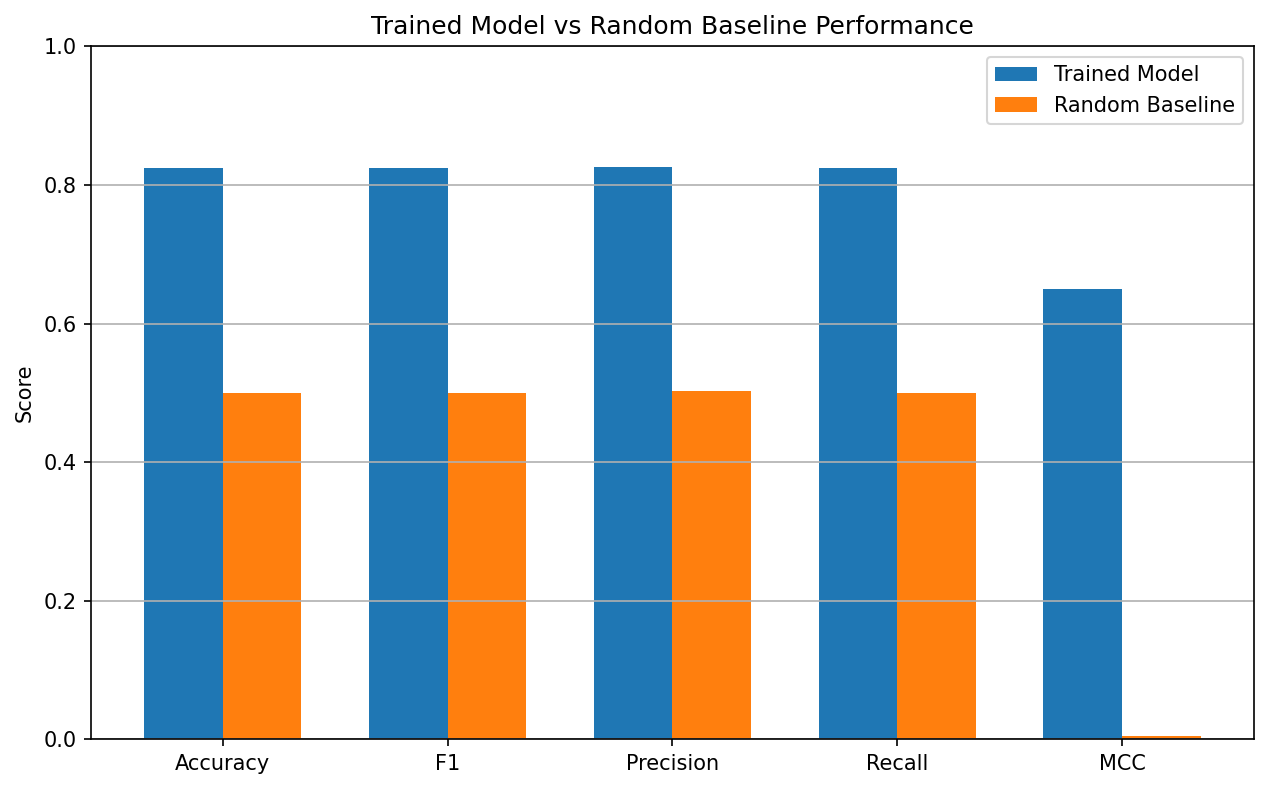

In [16]:
import matplotlib
matplotlib.use("Agg")  # ensure no inline display
import matplotlib.pyplot as plt

print("\n" + "=" * 70)
print("RANDOM BASELINE COMPARISON")
print("=" * 70)

# True labels from test set
true_labels = np.array(tokenized_datasets["test"][LABEL_COL])
n = len(true_labels)

# Generate RANDOM predictions (uniform 0/1)
random_preds = np.random.randint(0, 2, size=n)

# Compute random baseline metrics
random_metrics = {
    "accuracy": accuracy_metric.compute(predictions=random_preds, references=true_labels)["accuracy"],
    "f1": f1_metric.compute(predictions=random_preds, references=true_labels, average="weighted")["f1"],
    "precision": precision_metric.compute(predictions=random_preds, references=true_labels, average="weighted")["precision"],
    "recall": recall_metric.compute(predictions=random_preds, references=true_labels, average="weighted")["recall"],
    "mcc": mcc_metric.compute(predictions=random_preds, references=true_labels)["matthews_correlation"],
}

print("Model Metrics (test set):")
print(f"accuracy:  {test_metrics['eval_accuracy']:.4f}")
print(f"f1:        {test_metrics['eval_f1']:.4f}")
print(f"precision: {test_metrics['eval_precision']:.4f}")
print(f"recall:    {test_metrics['eval_recall']:.4f}")
print(f"mcc:       {test_metrics['eval_mcc']:.4f}")

print("\nRandom Baseline Metrics:")
for k, v in random_metrics.items():
    print(f"{k}: {v:.6f}")

# Prepare values for plotting
model_vals = [
    test_metrics["eval_accuracy"],
    test_metrics["eval_f1"],
    test_metrics["eval_precision"],
    test_metrics["eval_recall"],
    test_metrics["eval_mcc"],
]

random_vals = [
    random_metrics["accuracy"],
    random_metrics["f1"],
    random_metrics["precision"],
    random_metrics["recall"],
    random_metrics["mcc"],
]

metric_names = ["Accuracy", "F1", "Precision", "Recall", "MCC"]

x = np.arange(len(metric_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, model_vals, width, label="Trained Model")
plt.bar(x + width/2, random_vals, width, label="Random Baseline")

plt.xticks(x, metric_names)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Trained Model vs Random Baseline Performance")
plt.legend()
plt.grid(True, axis="y")

# Save plot
plot_path = "model_vs_random_baseline.png"
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
plt.close()

print(f"\nPlot saved to: {plot_path}")

from IPython.display import Image, display
display(Image("model_vs_random_baseline.png"))


In [17]:
from collections import Counter

print("Test label distribution:", Counter(true_labels))
print("Test size:", len(true_labels))


Test label distribution: Counter({np.int64(0): 129, np.int64(1): 117})
Test size: 246
